In [109]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

## Descrição do Problema

A Transferência de Estilo Neural (NST) combina duas imagens: uma <strong>"imagem de conteúdo" (C)</strong> e uma <strong>"imagem de estilo" (S)</strong>, para criar uma <strong>"imagem gerada" (G)</strong>. A imagem gerada G combina o "conteúdo" da imagem C com o "estilo" da imagem S.

## Aprendizado por Transferência

A Transferência de Estilo Neural (NST) utiliza uma rede convolucional previamente treinada e se baseia nela. A ideia de usar uma rede treinada em uma tarefa diferente e aplicá-la a uma nova tarefa é chamada de aprendizado por transferência.

Utilizaremos a rede homônima VGG do [artigo original da NST](https://arxiv.org/abs/1508.06576) publicado pelo Visual Geometry Group da Universidade de Oxford em 2014. Especificamente a VGG-19, uma versão de 19 camadas da rede VGG. Esse modelo já foi treinado no banco de dados ImageNet, que é muito grande, e aprendeu a reconhecer uma variedade de características de baixo nível (nas camadas mais rasas) e características de alto nível (nas camadas mais profundas).

In [110]:
# Definições iniciais
tf.random.set_seed(272) # Semente para reprodução de resultados
img_size = 400 # Tamanho das imagens

In [111]:
# Função para carregar imagens
def load_image(path, target_size):
    img = Image.open(path).resize((target_size, target_size)) # Carrega a imagem e redimensiona
    return np.array(img) # Converte a imagem para um array numpy

**Explicação**:
1. **Multiplicação por 255**: O tensor é multiplicado por 255 para converter os valores dos pixels do intervalo [0,0 - 1,0] para [0 - 255]. Isso é necessário para gerar uma imagem adequada para visualização.

2. **Conversão para NumPy**: O tensor é convertido para um array NumPy do tipo `uint8`, que é o tipo de dados usado para representar valores de pixels em imagens.

3. **Redução de Dimensão (se necessário)**: Se o tensor tiver mais de três dimensões e a primeira dimensão for 1 (representando o tamanho do lote de imagens), essa dimensão é eliminada para obter uma única imagem.

4. **Criação da Imagem PIL**: A partir do array NumPy, uma imagem PIL é criada usando `Image.fromarray`.

A função retorna uma imagem PIL criada a partir do tensor fornecido, que pode ser visualizada ou salva em disco.

In [112]:
def tensor_to_image(tensor):
    # Multiplica o tensor por 255 para converter para valores de pixels [0-255]
    tensor = tensor * 255

    # Converte o tensor em um array NumPy de tipo uint8
    tensor = np.array(tensor, dtype=np.uint8)
    
    # Verifica se o tensor tem mais de três dimensões e se a primeira dimensão é 1
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    
    # Retorna a imagem PIL criada a partir do array NumPy
    return Image.fromarray(tensor)

**Explicação**:
- A função `clip_0_1` utiliza a função `tf.clip_by_value` do TensorFlow para truncar (limitar) todos os valores dos pixels na imagem para ficarem dentro do intervalo [0.0, 1.0].
- Isso é útil para garantir que os valores dos pixels estejam dentro de um intervalo válido após operações que podem resultar em valores fora do intervalo.

Ao aplicar essa função a uma imagem representada por um tensor, todos os pixels que estiverem abaixo de 0.0 serão definidos para 0.0, e todos os pixels acima de 1.0 serão definidos para 1.0.

In [113]:
def clip_0_1(image):
    # Trunca todos os valores dos pixels da imagem para ficarem entre 0 e 1
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)


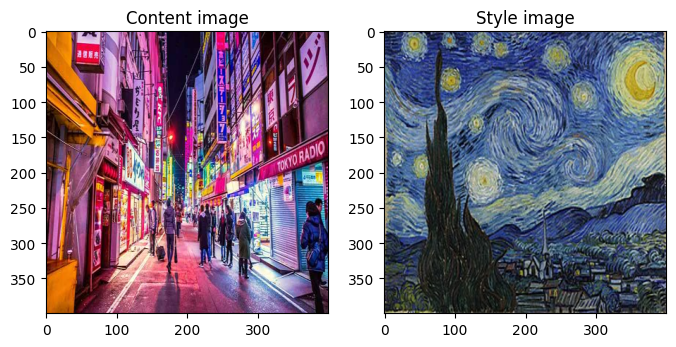

In [114]:
# Carregar imagens
content_image = load_image(r"C:\Users\arthu\Downloads\tokyo.jpg", img_size)
style_image = load_image(r"C:\Users\arthu\Downloads\Van_Gogh_-_Starry_Night.jpg", img_size)

# Mostrar as imagens
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(content_image)
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 2, 2)
ax.imshow(style_image)
ax.title.set_text('Style image')
plt.show()

**Explicação**

1. **Converter para tensores**:
   - **`content_image`**: A imagem de conteúdo é transformada em um tensor `tf.constant` e redimensionada para que tenha um formato que inclui uma dimensão extra no início (de tamanho 1), que é a dimensão de lote. Essa dimensão é adicionada para que a imagem seja compatível com modelos que esperam lotes de imagens como entrada.
     - A imagem também é convertida para `float32` e seus valores são divididos por 255.0 para ficarem no intervalo [0,0 - 1,0], normalizando a imagem para que os valores sejam adequados para processamentos subsequentes.
   - **`style_image`**: O mesmo processo é aplicado à imagem de estilo.

2. **Inicializar a imagem gerada**:
   - **`generated_image`**: A imagem gerada é inicializada a partir da imagem de conteúdo com ruído adicionado. Isso é feito somando à imagem de conteúdo um tensor de ruído uniforme que varia de -0.25 a 0.25. O uso de ruído inicializa a imagem gerada de maneira a conter um pouco do conteúdo da imagem de conteúdo, mas com bastante variabilidade, permitindo que o processo de otimização adapte a imagem para se assemelhar ao estilo desejado.

3. **Carregar o modelo VGG19**:
   - **`vgg`**: O modelo VGG19 é carregado a partir do TensorFlow com os seguintes parâmetros:
     - **`include_top=False`**: Indica que a última camada densa de classificação não será incluída, mantendo apenas as camadas convolucionais.
     - **`input_shape`**: Define a forma de entrada como (400, 400, 3), onde `400` é a largura e a altura, e `3` é o número de canais de cor (RGB).
     - **`weights='imagenet'`**: Indica que os pesos pré-treinados do modelo serão carregados a partir do conjunto de dados ImageNet.
   - **`vgg.trainable = False`**: Configura o modelo como não treinável, o que significa que seus pesos não serão atualizados durante o processo de otimização. Ele será usado apenas para extração de características e cálculos de custos.

In [115]:
# Converter para tensores
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)), dtype=tf.float32) / 255.0
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)), dtype=tf.float32) / 255.0
print(content_image.shape)

(1, 400, 400, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


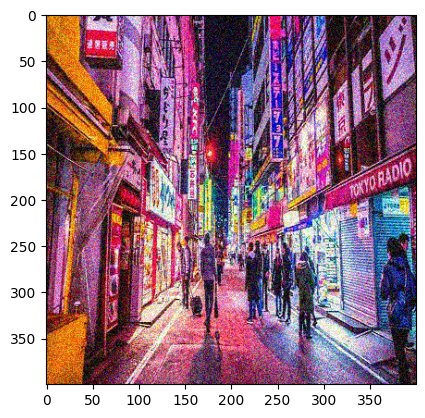

In [116]:
# Inicializar a imagem gerada
generated_image = tf.Variable(content_image + tf.random.uniform(tf.shape(content_image), -0.25, 0.25))
plt.imshow(np.squeeze(generated_image))

**Explicação**:

1. **`vgg`**:
   - O modelo VGG19 é carregado usando a função `tf.keras.applications.VGG19`.
   - Os argumentos passados para a função especificam configurações específicas do modelo.

2. **`include_top=False`**:
   - Este argumento indica que a parte superior do modelo, que é a camada de classificação, não deve ser incluída.
   - Isso é feito porque, para transferência de estilo neural, apenas as camadas convolucionais são necessárias para extrair as características visuais.

3. **`input_shape=(img_size, img_size, 3)`**:
   - Este argumento especifica a forma da entrada do modelo. `img_size` indica tanto a largura quanto a altura das imagens de entrada.
   - O número `3` indica que as imagens têm três canais, representando cores RGB.

4. **`weights='imagenet'`**:
   - Este argumento especifica que os pesos pré-treinados do modelo devem ser carregados a partir do conjunto de dados ImageNet.
   - Esses pesos permitem que o modelo tenha boas características visuais já aprendidas, prontas para serem usadas no processo de transferência de estilo.

5. **`vgg.trainable = False`**:
   - Esta linha torna todas as camadas do modelo não treináveis, ou seja, seus pesos não serão atualizados durante o treinamento.
   - Isso é feito porque o modelo é usado apenas para extração de características e cálculos de custos, não para ser ajustado ou treinado.

No geral, o modelo VGG19 é carregado para obter as ativações das camadas intermediárias necessárias para calcular os custos de estilo e conteúdo.

In [117]:
# Carregar o modelo VGG19
vgg = tf.keras.applications.VGG19(include_top=False, input_shape=(img_size, img_size, 3), weights='imagenet')
vgg.trainable = False

**Explicação**:
- **Propósito da função**: A função `get_model_outputs` cria um modelo Keras que retorna as saídas das camadas especificadas do modelo VGG19. Isso é útil para calcular os custos de estilo e conteúdo usando a Transferência de Estilo Neural.
  
1. **`vgg`**:
   - O modelo VGG19 previamente carregado que contém todas as camadas convolucionais.

2. **`style_layers` e `content_layer`**:
   - **`style_layers`**: Lista dos nomes das camadas que serão usadas para calcular o custo de estilo.
   - **`content_layer`**: Nome da camada usada para calcular o custo de conteúdo.

3. **`outputs`**:
   - A função percorre a lista combinada de camadas de estilo e conteúdo e obtém a saída (ativações) de cada camada no modelo VGG19 usando `vgg.get_layer(layer).output`.

4. **Retornar o Modelo**:
   - Um modelo Keras é criado usando `tf.keras.Model`, que tem a mesma entrada do modelo VGG19 (`vgg.input`), mas retorna apenas as ativações das camadas especificadas.
  
Este modelo retornado pode ser usado para obter as ativações das camadas selecionadas durante o processo de otimização para calcular os custos de estilo e conteúdo.

In [118]:
# Obter as saídas das camadas para conteúdo e estilo
def get_model_outputs(vgg, style_layers, content_layer):
    # Obter as saídas das camadas especificadas usando seus nomes
    outputs = [vgg.get_layer(layer).output for layer in style_layers + [content_layer]]
    
    # Cria um modelo que tem a mesma entrada da VGG, mas retorna as saídas das camadas especificadas
    return tf.keras.Model([vgg.input], outputs)

### Explicação:

1. **`STYLE_LAYERS`**:
   - Esta variável é uma lista contendo os nomes das camadas da rede VGG19 que serão usadas para calcular o custo de estilo.
   - Cada nome na lista refere-se a uma camada convolucional específica da rede, como `block1_conv1`, `block2_conv1` e assim por diante.
   - O uso de múltiplas camadas para calcular o custo de estilo ajuda a capturar diferentes níveis de detalhes e características de estilo da imagem de referência.

2. **`CONTENT_LAYER`**:
   - Esta variável é uma string contendo o nome da camada da rede VGG19 que será usada para calcular o custo de conteúdo.
   - Neste caso, `block5_conv4` é uma camada convolucional específica na rede que captura características detalhadas da imagem, tornando-a ideal para representar o conteúdo da imagem de referência.

In [119]:
for layer in vgg.layers:
    print(layer.name)

input_7
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [120]:
STYLE_LAYERS = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
CONTENT_LAYER = 'block5_conv4'

**Explicação**:

1. **`model_outputs`**:
   - A variável `model_outputs` armazena o modelo retornado pela função `get_model_outputs`.
   - Este modelo é configurado para retornar as saídas (ativações) das camadas listadas em `STYLE_LAYERS` e `CONTENT_LAYER`.

2. **`content_target`**:
   - Esta variável armazena as ativações da camada de conteúdo (`CONTENT_LAYER`) para a imagem de conteúdo (`content_image`).
   - O índice `[-1]` é usado para pegar a última camada de saída do modelo, que neste caso é a camada especificada por `CONTENT_LAYER`.

3. **`style_targets`**:
   - Esta variável armazena as ativações das camadas de estilo (`STYLE_LAYERS`) para a imagem de estilo (`style_image`).
   - O índice `[:-1]` é usado para pegar todas as camadas de saída exceto a última, que é a camada de conteúdo.
   - Isso retorna uma lista das ativações das camadas de estilo.

In [121]:
# Obter as saídas das camadas para conteúdo e estilo usando `get_model_outputs`
model_outputs = get_model_outputs(vgg, STYLE_LAYERS, CONTENT_LAYER)

# Obter as ativações da imagem de conteúdo para a camada especificada
content_target = model_outputs(content_image)[-1]

# Obter as ativações das imagens de estilo para as camadas especificadas
style_targets = model_outputs(style_image)[:-1]

**Explicação**:

1. **Parâmetros de Entrada**:
   - `content_output`: Ativações da camada de conteúdo para a imagem de conteúdo.
   - `generated_output`: Ativações da mesma camada para a imagem gerada.

2. **Recuperar Ativações**:
   - `a_C` e `a_G` recebem as ativações da última camada para a imagem de conteúdo e gerada, respectivamente.

3. **Obter Dimensões**:
   - As dimensões do tensor `a_G` (tamanho do lote `m`, altura `n_H`, largura `n_W`, e canais `n_C`) são obtidas para redimensionar as ativações.

4. **Redimensionar Ativações**:
   - `a_C_unrolled` e `a_G_unrolled` são criados redimensionando as ativações `a_C` e `a_G` para o formato `(m, n_H * n_W, n_C)`, o que torna mais fácil calcular a diferença entre elas.

5. **Calcular Custo de Conteúdo**:
   - `J_content` é calculado como a soma dos quadrados das diferenças entre as ativações redimensionadas de `a_C` e `a_G`.
   - A fórmula também inclui uma normalização pelo produto das dimensões `n_H`, `n_W`, e `n_C`.

6. **Retornar o Custo**:
   - A função retorna `J_content`, que é o valor escalar que representa o custo de conteúdo entre a imagem de conteúdo e a imagem gerada.

In [122]:
def compute_content_cost(content_output, generated_output):

    # Obtém as ativações da última camada para a imagem de conteúdo e a imagem gerada
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    # Recupera as dimensões de a_G 
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Redimensiona 'a_C' e 'a_G' 
    a_C_unrolled = tf.reshape(a_C, [m, n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, [m, n_H * n_W, n_C])
    
    # Calcula o custo com TensorFlow
    J_content = tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled)) / (4.0 * n_H * n_W * n_C)
    
    return J_content

- **Matriz de Gram**
  - Em álgebra linear, uma matriz de Gram é usada para encontrar a similaridade entre vetores. No contexto de redes neurais, a matriz de Gram é utilizada na Transferência de Estilo Neural para representar as correlações entre os filtros de uma camada convolucional.
  - Na Transferência de Estilo Neural, a matriz de Gram é usada para medir a similaridade de estilo entre a imagem gerada e a imagem de estilo.

- **Como a função funciona:**
  - **Entrada `A`:** Um tensor de dimensões `(n_C, n_H * n_W)` após o redimensionamento das ativações da camada convolucional.
    - `n_C` representa o número de filtros ou canais da camada.
    - `n_H` e `n_W` representam a altura e a largura da camada, respectivamente.
  - **Operação de Produto Matricial:** A matriz de Gram é calculada multiplicando `A` pela transposta de `A` usando `tf.matmul`.
    - `tf.matmul(A, tf.transpose(A))` calcula a matriz de Gram que contém as correlações entre os diferentes filtros.

- **Retorno:**
  - A função retorna a matriz de Gram de `A`, que é uma matriz de dimensões `(n_C, n_C)`.
  - Ela representa a similaridade entre os filtros e será usada para calcular o custo de estilo.

A matriz de Gram resultante é então comparada entre a imagem de estilo e a imagem gerada para determinar o quão similar é o estilo entre as duas.

In [123]:
def gram_matrix(A):   
    # Calcular a matriz de Gram de A
    return tf.matmul(A, tf.transpose(A))

**Explicação**:

1. **Parâmetros de Entrada**:
   - `a_S`: As ativações da camada oculta para a imagem de estilo.
   - `a_G`: As ativações da camada oculta para a imagem gerada.

2. **Recuperar Dimensões**:
   - As dimensões do tensor `a_G` (tamanho do lote `m`, altura `n_H`, largura `n_W`, e canais `n_C`) são obtidas para redimensionar as ativações.

3. **Redimensionar Ativações**:
   - `a_S` e `a_G` são redimensionados para uma matriz 2D com forma `(n_C, n_H * n_W)`, o que torna mais fácil calcular a matriz de Gram.

4. **Calcular Matrizes de Gram**:
   - `GS` e `GG` representam as matrizes de Gram calculadas para `a_S` e `a_G`, respectivamente, usando a função `gram_matrix`.

5. **Calcular Custo de Estilo**:
   - `J_style_layer` é calculado como a soma dos quadrados das diferenças entre as matrizes de Gram de `GS` e `GG`.
   - A fórmula inclui uma normalização pelo produto de `n_C**2` e `(n_H * n_W)**2`.

6. **Retornar o Custo**:
   - A função retorna `J_style_layer`, que é o valor escalar que representa o custo de estilo para a camada oculta específica entre a imagem de estilo e a imagem gerada.

In [124]:
def compute_layer_style_cost(a_S, a_G):
    
    # Obtém as dimensões de a_G 
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Redimensiona os tensores de (1, n_H, n_W, n_C) para (n_C, n_H * n_W)
    a_S = tf.reshape(a_S, shape=[n_H * n_W, n_C])
    a_S = tf.transpose(a_S)
    a_G = tf.reshape(a_G, shape=[n_H * n_W, n_C])
    a_G = tf.transpose(a_G)

    # Calcula as matrizes de Gram para as imagens S e G
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Calcula a perda
    J_style_layer = tf.reduce_sum(tf.square(GS - GG)) / (4.0 * n_C**2 * (n_H * n_W)**2)
    
    return J_style_layer


**Explicação**:

1. **Parâmetros de Entrada**:
   - **`style_image_output`**: Saídas do modelo para a imagem de estilo.
   - **`generated_image_output`**: Saídas do modelo para a imagem gerada.
   - **`STYLE_LAYERS`**: Lista de camadas de estilo com seus respectivos coeficientes.

2. **Inicializar Custo de Estilo**:
   - `J_style` é inicializado como zero para acumular o custo total de estilo.

3. **Obter Ativações de Estilo**:
   - `a_S` e `a_G` contêm as ativações das camadas de estilo para a imagem de estilo e a imagem gerada, respectivamente.
   - O último elemento das saídas é excluído, pois é a camada de conteúdo.

4. **Iterar Sobre as Camadas de Estilo**:
   - Para cada camada em `STYLE_LAYERS`, `compute_layer_style_cost` é chamado para calcular o custo de estilo da camada atual.
   - O custo de estilo da camada é ponderado pelo coeficiente associado e adicionado a `J_style`.

5. **Retornar Custo de Estilo**:
   - A função retorna `J_style`, que é o custo total de estilo calculado a partir das várias camadas especificadas.

O custo de estilo é usado para guiar a otimização da imagem gerada para se assemelhar ao estilo da imagem de referência.

In [125]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):

    # Inicializa o custo de estilo geral
    J_style = 0

    # Define a_S como a ativação da camada oculta da camada que selecionamos
    # O último elemento da matriz contém a imagem da camada de conteúdo, que não deve ser usada
    a_S = style_image_output[:-1]

    # Define a_G como a saída das camadas ocultas escolhidas
    # O último elemento da lista contém a imagem da camada de conteúdo, que não deve ser usada
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):
        # Calcula o custo de estilo para a camada atual
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Adiciona weight * J_style_layer desta camada ao custo de estilo geral
        J_style += weight[1] * J_style_layer

    return J_style


**Explicação**:

1. **Otimizador**:
   - O otimizador Adam é inicializado com uma taxa de aprendizado de 0,01 para otimizar a imagem gerada.

2. **`train_step`**:
   - A função `train_step` executa uma etapa de treinamento para otimizar a imagem gerada.
   
   - **`tf.GradientTape`**: Usado para gravar as operações e calcular os gradientes.
   
   - **Ativações das Camadas**: `outputs` contém as ativações das camadas para a imagem gerada.

   - **Cálculo do Custo de Conteúdo**: `J_content` é calculado comparando as ativações da imagem gerada com as ativações da imagem de conteúdo.
   
   - **Cálculo do Custo de Estilo**: `J_style` é calculado como a soma dos custos de estilo de todas as camadas de estilo.
   
   - **Custo Total**: `J` é calculado como uma combinação ponderada dos custos de conteúdo e estilo.
   
   - **Gradientes e Aplicação**: Os gradientes são calculados em relação ao custo total e aplicados à imagem gerada usando o otimizador.
   
   - **Truncar Valores de Pixels**: Os valores dos pixels são truncados para ficarem no intervalo [0,0 - 1,0].

Este processo guia a imagem gerada para se assemelhar ao conteúdo da imagem de referência e ao estilo da imagem de estilo.

In [126]:
# Inicializa o otimizador Adam com uma taxa de aprendizado de 0,01
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_step(generated_image):
    # Usando tf.GradientTape para monitorar as operações para calcular gradientes
    with tf.GradientTape() as tape:
        # Calcula as ativações das camadas para a imagem gerada
        outputs = model_outputs(generated_image)
        
        # Calcula o custo de conteúdo usando as ativações da camada de conteúdo
        J_content = compute_content_cost(content_target, outputs[-1])
        
        # Calcula o custo de estilo somando os custos das camadas de estilo
        J_style = sum(compute_style_cost(style_targets[i], outputs[i]) for i in range(len(STYLE_LAYERS)))
        
        # Calcula o custo total como a soma ponderada dos custos de conteúdo e estilo
        J = J_content + 0.01 * J_style

    # Calcula o gradiente do custo em relação à imagem gerada
    grad = tape.gradient(J, generated_image)
    
    # Aplica os gradientes usando o otimizador
    optimizer.apply_gradients([(grad, generated_image)])
    
    # Trunca os valores dos pixels da imagem gerada para ficarem entre 0 e 1
    generated_image.assign(clip_0_1(generated_image))


In [127]:
epochs = 2000
for i in range(epochs):
    train_step(generated_image)
    if i % 200 == 0:
        image = tensor_to_image(generated_image)
        plt.imshow(image)
        plt.title(f'Epoch {i}')
        plt.show()
        print(f'Epoch {i}, Content Cost: {compute_content_cost(content_target, model_outputs(generated_image)[-1]).numpy()}')

ValueError: in user code:

    File "C:\Users\arthu\AppData\Local\Temp\ipykernel_6232\3768729204.py", line 12, in train_step  *
        J_content = compute_content_cost(content_target, outputs[-1])
    File "C:\Users\arthu\AppData\Local\Temp\ipykernel_6232\2891455651.py", line 8, in compute_content_cost  *
        m, n_H, n_W, n_C = a_G.get_shape().as_list()

    ValueError: not enough values to unpack (expected 4, got 3)


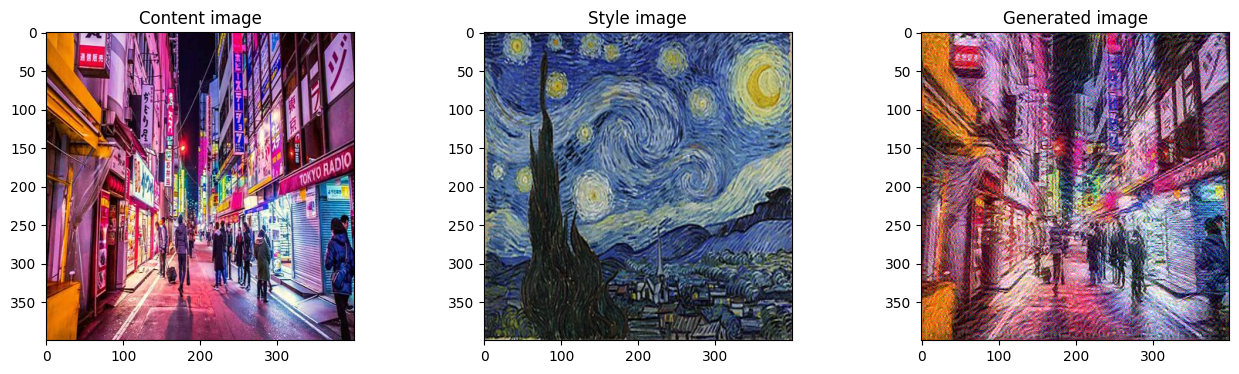

In [ ]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
ax.imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
ax.imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()
